In [1]:
import glob
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import signal
from sklearn.decomposition import PCA
from random import randint

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

%matplotlib inline

In [2]:
from utils.ssim import ssim

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [4]:
PREDICTED_FRAME = [-1]
NO_MAX_FRAMES = (50, 100, 200, 400)
NO_FRAMES_PREDICTED_AHEAD = (1, 6, 18, 36)
SIZE_FRAGMENT = [3]
COLOR_S = ('red', 'green', 'blue')

#### Model

In [5]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        no_filters = 2048
        self.conv1 = nn.Conv2d(1, no_filters, kernel_size=(3, 3))
        self.linear1 = nn.Linear(no_filters, 32)
        self.linear2 = nn.Linear(32, 1)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))
        x = x.view(x.shape[0], -1)
        x = self.linear1(x)
        x = torch.sigmoid(self.linear2(x))
        return x

#### Loading images

In [6]:
files_s = np.array(sorted(glob.glob('data/frames/*')))
print(f'Number of files: {len(files_s)}')

Number of files: 417


In [7]:
image_s = []
for i in range(len(files_s)):
    filename = files_s[i]
    image = cv2.imread(filename)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_s.append(image)
image_s = np.array(image_s)
image_s = image_s.reshape(image_s.shape[0], 3, image_s.shape[1], image_s.shape[2])
print(image_s.shape)

(417, 3, 1000, 1000)


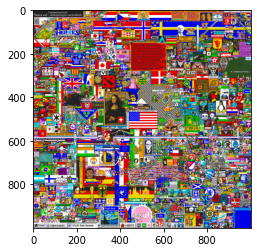

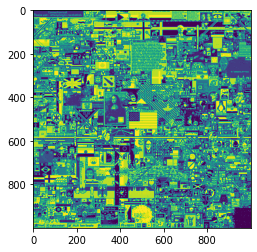

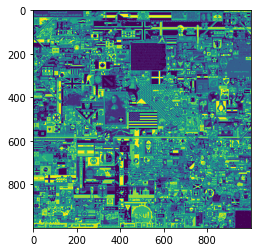

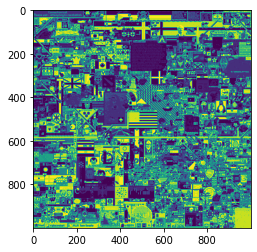

In [8]:
img = image_s.reshape(-1, 1000, 1000, 3)
plt.imshow(img[-1])
plt.show()

img_red_channel_s = img[:, :, :, 0].reshape(img.shape[0], 1, 1000, 1000)
plt.imshow(img_red_channel_s[-1, 0])
plt.show()

img_green_channel_s = img[:, :, :, 1].reshape(img.shape[0], 1, 1000, 1000)
plt.imshow(img_green_channel_s[-1, 0])
plt.show()

img_blue_channel_s = img[:, :, :, 2].reshape(img.shape[0], 1, 1000, 1000)
plt.imshow(img_blue_channel_s[-1, 0])
plt.show()

In [9]:
def inference(filepath, image_s,
              color, frame_to_predict, no_frames, no_frames_predicted, size):
    # Loading model
    model = CNN().to(device)
    model.load_state_dict(torch.load(filepath, map_location=torch.device('cpu')))
    for param in model.parameters():
        param.requires_grad = False

    # Frame as input
    test_x = image_s[frame_to_predict-no_frames_predicted].reshape(1000, 1000)
    test_y = image_s[frame_to_predict].reshape(1000, 1000)
    test_y = test_y[1:-1, 1:-1]

    x_test_batch = []
    for i in range(998):
        row = []
        for j in range(998):
            x_test = test_x[i:i+3, j:j+3] / 255
            row.append(x_test)        
        x_test_batch.append(row)
    x_test_batch = np.array(x_test_batch).reshape(998, 998, 1, 3, 3)
    x_test_batch = torch.tensor(x_test_batch).float().to(device)
    
    test_x = test_x[1:-1, 1:-1]

    output = []
    for i in range(998):
        p = model(x_test_batch[i]).detach().cpu().reshape(998).tolist()
        output.append(p)
    output = np.array(output) * 255
    
    plt.imsave(
        f'data/frame_prediction/images/input_{color}_noFrames{no_frames}_noFramesPredicted{no_frames_predicted}_size{size}.png', 
        test_x,
        cmap='binary'
    )
    plt.close()

    plt.imsave(
        f'data/frame_prediction/images/outputReal_{color}_noFrames{no_frames}_noFramesPredicted{no_frames_predicted}_size{size}.png', 
        test_y,
        cmap='binary'
    )
    plt.close()

    plt.imsave(
        f'data/frame_prediction/images/outputPred_{color}_noFrames{no_frames}_noFramesPredicted{no_frames_predicted}_size{size}.png', 
        output,
        cmap='binary'
    )
    plt.close()

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(test_x, cmap='binary')
    axs[0].set_title('Input')
    axs[1].imshow(test_y, cmap='binary')
    axs[1].set_title('Output real')
    axs[2].imshow(output, cmap='binary')
    axs[2].set_title('Output pred')
    fig.tight_layout()
    fig.savefig(
        f'data/frame_prediction/combined/{color}_noFrames{no_frames}_noFramesPredicted{no_frames_predicted}_size{size}.png', 
    )
    plt.close()

    img1, img2 = test_y, output
    ssim_index_11, ssim_map_11 = ssim(img1, img2, size_window=11)
    ssim_index_1, ssim_map_1 = ssim(img1, img2, size_window=1)
    
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(img1, cmap='binary')
    axs[0].set_title(f'Real')
    axs[1].imshow(img2, cmap='binary')
    axs[1].set_title(f'Pred')
    axs[2].imshow(ssim_map_11, cmap='binary')
    axs[2].set_title(f'Residual map')
    plt.tight_layout()
    plt.savefig(f'data/frame_prediction/ssim_11window/{color}_noFrames{no_frames}_noFramesPredicted{no_frames_predicted}_size{size}.png')
    plt.close()

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(img1, cmap='binary')
    axs[0].set_title(f'Real')
    axs[1].imshow(img2, cmap='binary')
    axs[1].set_title(f'Pred')
    axs[2].imshow(ssim_map_1, cmap='binary')
    axs[2].set_title(f'Residual map')
    plt.tight_layout()
    plt.savefig(f'data/frame_prediction/ssim_1window/{color}_noFrames{no_frames}_noFramesPredicted{no_frames_predicted}_size{size}.png')
    plt.close()

    img1, img2 = test_y, test_x
    ssim_index_11_baseline, ssim_map_11_baseline = ssim(img1, img2, size_window=11)
    ssim_index_1_baseline, ssim_map_1_baseline = ssim(img1, img2, size_window=1)

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(img1, cmap='binary')
    axs[0].set_title(f'Real')
    axs[1].imshow(img2, cmap='binary')
    axs[1].set_title(f'Pred')
    axs[2].imshow(ssim_map_11_baseline, cmap='binary')
    axs[2].set_title(f'Residual map')
    plt.tight_layout()
    plt.savefig(f'data/frame_prediction/ssim_11window_baseline/{color}_noFrames{no_frames}_noFramesPredicted{no_frames_predicted}_size{size}.png')
    plt.close()
    
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(img1, cmap='binary')
    axs[0].set_title(f'Real')
    axs[1].imshow(img2, cmap='binary')
    axs[1].set_title(f'Pred')
    axs[2].imshow(ssim_map_1_baseline, cmap='binary')
    axs[2].set_title(f'Residual map')
    plt.tight_layout()
    plt.savefig(f'data/frame_prediction/ssim_1window_baseline/{color}_noFrames{no_frames}_noFramesPredicted{no_frames_predicted}_size{size}.png')
    plt.close()

    return ssim_index_11, ssim_index_1, ssim_index_11_baseline, ssim_index_1_baseline

In [ ]:
results_s = []
for frame_to_predict in PREDICTED_FRAME:
    for no_frames in NO_MAX_FRAMES:
        for no_frames_predicted in NO_FRAMES_PREDICTED_AHEAD:
            for size in SIZE_FRAGMENT:
                for color in COLOR_S:
                    filepath = f'checkpoints/{color}/model_noFrames{no_frames}_noFramesPredicted{no_frames_predicted}_size{size}.pt'

                    if color == 'red':
                        ssim_index_11, ssim_index_1, ssim_index_11_baseline, ssim_index_1_baseline = inference(
                                                                filepath, 
                                                                img_red_channel_s, 
                                                                color, 
                                                                frame_to_predict,
                                                                no_frames,
                                                                no_frames_predicted,
                                                                size)
                    elif color == 'green':
                        ssim_index_11, ssim_index_1, ssim_index_11_baseline, ssim_index_1_baseline = inference(
                                                                filepath, 
                                                                img_green_channel_s, 
                                                                color, 
                                                                frame_to_predict,
                                                                no_frames,
                                                                no_frames_predicted,
                                                                size)

                    elif color == 'blue':
                        ssim_index_11, ssim_index_1, ssim_index_11_baseline, ssim_index_1_baseline = inference(
                                                                filepath, 
                                                                img_blue_channel_s, 
                                                                color, 
                                                                frame_to_predict,
                                                                no_frames,
                                                                no_frames_predicted,
                                                                size)
                    else:
                        sys.exit()

                    ssim_11 = 0
                    ssim_1 = 0

                    results = []
                    results.append(color)
                    results.append(frame_to_predict)
                    results.append(no_frames)
                    results.append(no_frames_predicted)
                    results.append(size)
                    results.append(round(ssim_index_11, 4))
                    results.append(round(ssim_index_11_baseline, 4))
                    results.append(round(ssim_index_1, 4))
                    results.append(round(ssim_index_1_baseline, 4))
                    results_s.append(results)

    df_results = pd.DataFrame(results_s,
        columns=['color', 'frame_to_psredict', 'max_trained_frame', 'predicted_frame', 
                 'size_window', 'ssim_11', 'ssim_11_baseline', 'ssim_1', 'ssim_1_baseline'])
    df_results.to_csv('results.csv', index=False)